# CESM-LE analysis
### Looks at changes in soil moisture stress w/ changes in snow
 - reading in ensemble of data from CESM2_LENS
 - here, looking at monthly SNOWDP, BTRANMN, SoilWater_10cm
 - file IO from daniel kennedy, djk2120@ucar.edu
 - modified will wieder, wwieder@ucar.edu

In [2]:
%load_ext autoreload
%autoreload 2
import glob
import os

import cftime
import dask
import FWI_Wang2015 as fwi  # Jackie's python script
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.lines as mlines
import matplotlib.dates as mdates
import cartopy.crs as ccrs

import numba
import numpy as np
import pandas as pd
import xarray as xr
from scipy import stats
from tqdm.auto import tqdm
from distributed import wait
#dask.config.set({'distributed.dashboard.link': '/proxy/{port}/status'})

%matplotlib inline

In [3]:
## was working with 16.2
xr.__version__

'0.17.0'

In [4]:
## was working with 2021.01.0
dask.__version__

'2021.02.0'

### run this cell to check if you have LENS2 read access:

In [5]:
samplefile = ('/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1001.001/'+
              'lnd/proc/tseries/month_1/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.clm2.h0.NBP.199001-199912.nc')
cmd = 'stat '+samplefile
if os.system(cmd)!=0:
    print('you may not have access')
else:
    print('looks good')

looks good


### Fetch cluster

In [6]:
# For use on Casper: ONLY RUN THIS CELL ONCE
# note you may need to change the project number
# Anderson recommended "Reduce the number of dask-workers (from 36 to 18)
#    to allow dask to allocate more memory to each worker"
ncores = 10
nmem = str(int(400 * ncores / ncores)) + 'GB'
from dask.distributed import Client
from ncar_jobqueue import NCARCluster

cluster = NCARCluster(
    cores=ncores,
    processes=ncores,
    memory=nmem,
    #project='P93300641',
    walltime='1:00:00',
    extra=["--lifetime", "55m", "--lifetime-stagger", "4m"],
)
# cluster.scale(ncores)
cluster.adapt(minimum_jobs=1, maximum_jobs=3)  # change to 9 w/ 50 ens members
client = Client(cluster)

In [7]:
#cluster.close()

In [8]:
# the extra workers can get stuck in the queue
#   stay here (rerunning cell) until you see that the workers>0
cluster

# If not running, check the following on command line
# squeue -u wwieder see that the job is not yet running
# cancel any orphaned workers, e.g `scancel ########`

### Some helpful functions:
 - run all these before proceeding to the start here area:
 - you can certainly edit these, but shouldn't need to

In [10]:
#client.restart()

In [11]:
def get_members(model):
    members = []
    if model =='CESM1':
        members = [str(i).zfill(3) for i in [*(1+np.arange(35)),*(101+np.arange(7))]]
    else:
        for i,j in zip(1001+20*np.arange(10),1+np.arange(10)):
            s = 'LE2-'+str(i)+'.'+str(j).zfill(3)
            members.append(s)
        for i in [1231,1251,1281,1301]:
            for j in 1+np.arange(10):
                s = 'LE2-'+str(i)+'.'+str(j).zfill(3)
                members.append(s)
    return members

In [12]:
def file_dict(model,mem,field,hist=True,freq='monthly'):
    ''' returns a dictionary of filepaths keyed by year, for a given ensemble member '''
    mm = get_members(model)[mem]
    filepaths = {}
    
    if model=='CESM1':
        #detailing the directory structure
        topdir = '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/lnd/proc/tseries/'
        if freq =='monthly': 
            freq = 'monthly/'
            tape = '.h0.'
        else:
            raise ValueError('ERROR: \''+freq+'\' freq not supported for '+model)
        thisdir = topdir+freq+field+'/'
        if hist: runtype = 'b.e11.B20TRC5CNBDRD.f09_g16.'
        else:    runtype = 'b.e11.BRCP85C5CNBDRD.f09_g16.'
        #find all the relevant files
        files = glob.glob(thisdir+runtype+'*'+tape+field+'*')
    else:
        #detailing the directory structure
        topdir  = '/glade/campaign/cesm/collections/CESM2-LE/archive/'
        lnd     = '/lnd/proc/tseries/'
        if hist: runtype = 'b.e21.BHISTcmip6.f09_g17.'
        else:    runtype = 'b.e21.BSSP370cmip6.f09_g17.'
        if freq=='monthly':
            freq    = 'month_1/'
            tape    = '.h0.'
        elif freq=='daily':
            freq    = 'day_1/'
            tape    = '.h5.'
        else:
            raise ValueError('ERROR: \''+freq+'\' freq not supported for '+model)
        thisdir = topdir+runtype+mm+lnd+freq
        #find all the relevant files
        files = glob.glob(thisdir+'*'+tape+field+'*')
        
    for file in files:
        #isolate y1 and y2 from the file name
        ystr = file.split(field)[-1]
        y1 = int(ystr[1:5])
        ystr = ystr.split('-')[1]
        y2 = int(ystr[0:4])
        for yy in np.arange(y1,y2+1):
            filepaths[yy]=file
        
    return filepaths


In [13]:
def get_file(model,mem,field,year,freq='monthly'):
    ''' get a single file for the given model-mem-field-year'''
    hist = True
    if model=='CESM1' and year>2005: hist=False
    if model=='CESM2' and year>2014: hist=False

    filepaths = file_dict(model,mem,field,hist,freq)
    if year in filepaths.keys():
        file = filepaths[year]
    else:
        print('file not found for that member')
        file = []
    
    return file

In [14]:
def all_files(model,ens,field,firstyear,lastyear,freq='monthly'):
    ''' retrieve a list of files containing the given ensemble'''
    ens = np.array(ens)
    yrs = np.arange(firstyear,lastyear+1)
    files = []    # a list of lists, dim0=ens, dim1=time
    ix = np.zeros(ens.shape)+1
    
    for ee,i in zip(ens,range(len(ens))):
        ffs = []  # a list of files for this ee
        file0 = ''
        first = True
        for yr in yrs:
            #fetch filepaths
            if first:
                hist = True
                if model=='CESM1' and yr>2005: hist=False
                if model=='CESM2' and yr>2014: hist=False
                filepaths = file_dict(model,ee,field,hist,freq)
                first     = False  
            #append file if it is new
            if yr in filepaths.keys():
                file = filepaths[yr]
                if file != file0:
                    ffs.append(file)
                    file0 = file

            #trigger new filepaths fetch when needed
            if model=='CESM1' and yr==2005: first=True
            if model=='CESM2' and yr==2014: first=True

        
        #append this ensemble member to files
        if ffs:  #only append if you found files
            files.append(ffs)
        else:
            ix[i] = 0
    return files,ens[ix==1]

In [15]:
def get_data(model,ens,fields,firstyear,lastyear,freq,chunks={'time':1000}):
    ''' returns an xarray dataset containing the requested ensemble
    model = \'CESM1\' or \'CESM2\'
    ens   = list of members, via simple sequential key e.g. range(50) gets the first 50 members
            [0,2,4] would get the first, third, and fifth ensemble members (see get_members)
    fields = list of desired fields, you do not need to ask for lat/lon/time
    firstyear = int [1850-2100]
    lastyear  = int [1850-2100]
    freq = \'monthly\' or \'daily\' '''

    ds = xr.Dataset()    #instantiate Dataset

    #allow for single field or list of fields
    if type(fields)==str: fields=[fields]  
    
    #add fields one at a time to the dataset
    for field in fields:
        files,ens = all_files(model,ens,field,firstyear,lastyear,freq)
        ensdim  = xr.DataArray(ens, dims='ens', name='ens')
        dims    = [ensdim,'time']
        # check if all members have the same number of files (not guaranteed)
        nfs = np.array([len(ffs) for ffs in files])
        if np.sum(nfs==nfs[0])==len(nfs):
            one_go=True   # same number of files
        else:
            one_go=False
        if one_go: #read all data in one go
            tmp = xr.open_mfdataset(files,combine='nested',parallel=True,
                                    concat_dim=dims,chunks=chunks)
        else:      #read data one member at a time and then concat
            dsets = []
            for ffs in files:
                d0 = xr.open_mfdataset(ffs,combine='nested',parallel=True,
                                    concat_dim=['time'],chunks=chunks)
                dsets.append(d0)
            tmp = xr.concat(dsets,dim=ensdim)
        ds[field] = tmp[field]

    #grab one copy of the various extra variables, e.g. landfrac,area
    tmp = xr.open_dataset(files[0][0])
    for thisvar in tmp.data_vars:
        if 'time' not in tmp[thisvar].coords:
            ds[thisvar]=tmp[thisvar]

    # quick fix to adjust time vector for monthly data        
    if freq=='monthly':
        nmonths = len(ds.time)
        yr0 = ds['time.year'][0].values
        ds['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')

    return ds.sel(time=slice(str(firstyear),str(lastyear)))

In [16]:
def get_landarea(model):
    file= get_file(model,0,'GPP',1990)
    ds = xr.open_dataset(file)
    la = ds['area']*ds['landfrac']
    return la

--------------------
## Start editing here:
### Actually read in data

In [18]:
%%time
model = 'CESM2'
ens = 10+np.arange(5)
# not sure why QRUNOFF won't read in correctly...
fields = ['SNOWDP','GPP','BTRANMN',
          'SOILWATER_10CM','QRUNOFF_TO_COUPLER','QVEGT']#,
#          'RAIN','SNOW']
firstyear = 1850
lastyear  = 2100
freq      = 'monthly'

ds = get_data(model,ens,fields,firstyear,lastyear,freq).persist()
ds.nbytes/1e9 #GB

CPU times: user 16.2 s, sys: 566 ms, total: 16.8 s
Wall time: 22 s


20.025583188

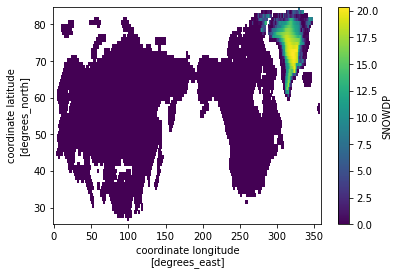

In [19]:
# we'll just look at 23-80 N for convenience
ds = ds.sel(lat=slice(25,85))
s2d = 3600 * 24

# mask out regions with very little snow or that never melt out
minSnow = 0.1
ds = ds.where(ds.SNOWDP.max('time')>minSnow) 
NotAllSnow = ds.SNOWDP.isel(time=slice(-120,None)).min(dim=['ens','time'])
NotAllSnow.plot()
ds = ds.where(NotAllSnow==0) 
#print(ds.QVEGT)

#### Mess with units
* convert to daily fluxes
* mask out BTRAN when GPP = 0 

In [20]:
ds['GPP'] = ds.GPP*s2d
ds['GPP'].attrs['units'] = 'gC/m2/d'

ds['QRUNOFF'] = ds.QRUNOFF_TO_COUPLER*s2d
ds['QRUNOFF'].attrs['units'] = 'mm/d'

#ds['TSOI_10CM'] = ds.TSOI_10CM-273.15
#ds['TSOI_10CM'].attrs['units'] = 'degC'
ds['QVEGT'] = ds.QVEGT*s2d
ds['QVEGT'].attrs['units'] = 'mm/d'

#ds['PRECIP'] = (ds.RAIN+ds.SNOW)*s2d
#ds['PRECIP'].attrs['units'] = 'mm/d'

ds['BTRANMN'] = ds['BTRANMN'].where(ds['GPP']>0)

#### Climatology from first and last decade 

In [21]:
IniClimo = ds.isel(time=slice(0,120)).groupby("time.month").mean("time").compute()
FinClimo = ds.isel(time=slice(-120,None)).groupby("time.month").mean("time").compute()
#print(IniClimo.SNOWDP)

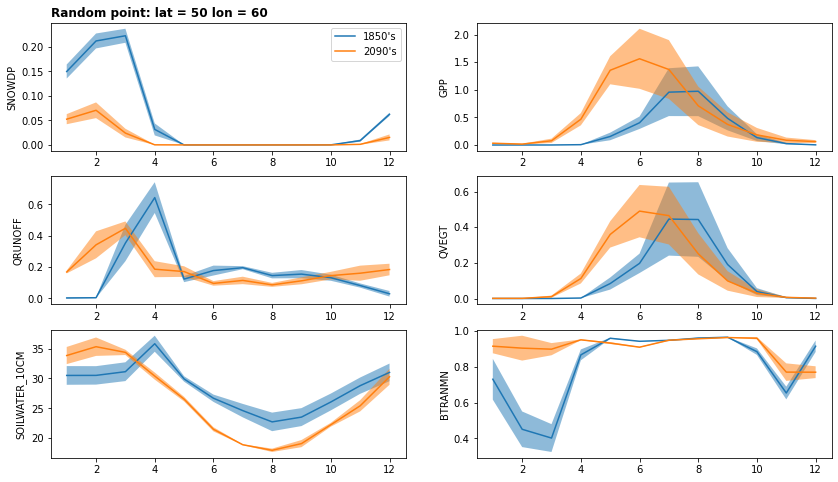

In [22]:
# organize plots
fields = ['SNOWDP','GPP',
          'QRUNOFF','QVEGT',
          'SOILWATER_10CM','BTRANMN']

#plat, plon, site =  39 , 253  , 'Crested Butte, CO' 
#plat, plon, site = 64.8, 212.4, 'Fairbanks, AK'
plat, plon, site =  50 , 60  , 'Random point' 

IniPlot = IniClimo.sel(lat = plat, lon = plon, method='nearest')
FinPlot = FinClimo.sel(lat = plat, lon = plon, method='nearest')
plt.figure(figsize=[14,8])
p = 0
for i in range(len(fields)):
    p = p+1
    plt.subplot(3,2,p)
    x = IniPlot.month
    y = IniPlot[fields[i]].mean('ens')
    y2 = IniPlot[fields[i]].std('ens')
    z  = FinPlot[fields[i]].mean('ens')
    z2 = FinPlot[fields[i]].std('ens')
    plt.plot(x,y)
    plt.fill_between(x, y - y2, y + y2, alpha=0.5)
    plt.plot(x,z)
    plt.fill_between(x, z - z2, z + z2, alpha=0.5)
    plt.ylabel(fields[i]) 
    if i == 0: 
        plt.title(site+': lat = '+str(plat)+' lon = '+str(plon), 
                         loc='left', fontsize='large', fontweight='bold') 
        plt.legend(["1850's","2090's"])
    else: plt.title(" ") ;

----------------
* How to best aggregate these data?  
* Just look at July differences ?
* decadal climatology ?
* Regional changes?
* Could look at water yield too (annual runoff as fraction of total precip)

### Changes in runoff may be clearer with monthly data?

In [26]:
IniClimoMean = IniClimo.mean('ens').compute()
FinClimoMean = FinClimo.mean('ens').compute()

### Changes in July soil moisture (10 cm)

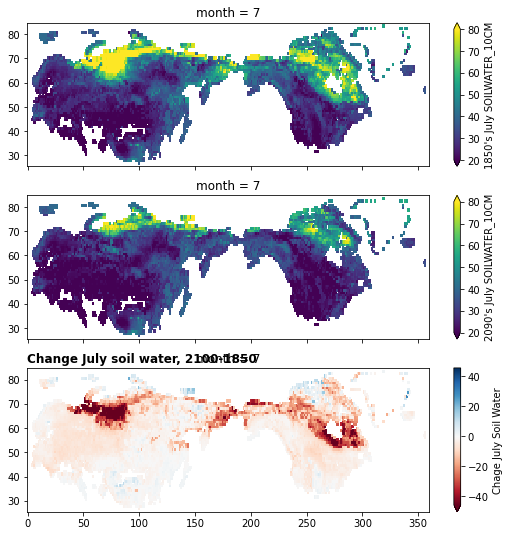

In [53]:
# Number of snow free days
plotVar = 'SOILWATER_10CM'
f, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(9, 9),sharex='col')
#ax1.set_title('Snow Free Days, 1850',loc='left', fontsize='large', fontweight='bold')
IniClimoMean[plotVar].isel(month=6).plot(
    ax=ax1, vmax=80,vmin=20,
    cbar_kwargs={'label': "1850's July "+plotVar}) 
ax1.set_xlabel('')
ax1.set_ylabel('')

# free days 2100 
#ax2.set_title('Snow Free Days, 2100',loc='left', fontsize='large', fontweight='bold')
FinClimoMean[plotVar].isel(month=6).plot(
    ax=ax2, vmax=80,vmin=20 ,
    cbar_kwargs={'label': "2090's July "+plotVar}) 
ax2.set_xlabel('')
ax2.set_ylabel('')

# Change in snow free days 2100 - 1901
ax3.set_title('Change July soil water, 2100-1850',loc='left', fontsize='large', fontweight='bold')
(FinClimoMean[plotVar]-IniClimoMean[plotVar]).isel(month=6).plot(
    ax=ax3, robust=True , cmap='RdBu',
    cbar_kwargs={'label': 'Chage July Soil Water'}) ;
ax3.set_xlabel('')
ax3.set_ylabel('') ;



### Changes in July BTRANMN

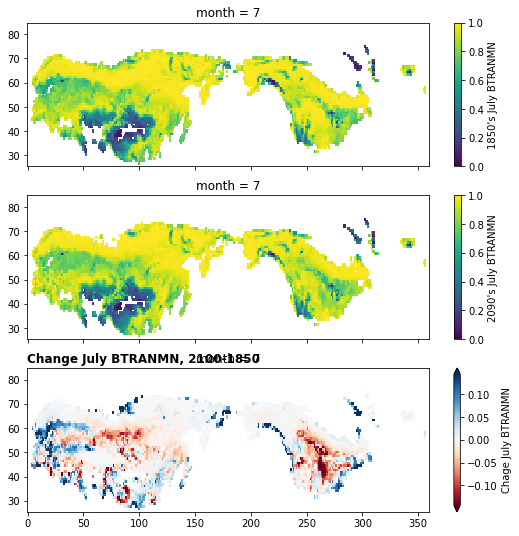

In [54]:
# Number of snow free days
plotVar = 'BTRANMN'
f, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(9, 9),sharex='col')
#ax1.set_title('Snow Free Days, 1850',loc='left', fontsize='large', fontweight='bold')
IniClimoMean[plotVar].isel(month=6).plot(
    ax=ax1, vmax=1,vmin=0,
    cbar_kwargs={'label': "1850's July "+plotVar}) 
ax1.set_xlabel('')
ax1.set_ylabel('')

# free days 2100 
#ax2.set_title('Snow Free Days, 2100',loc='left', fontsize='large', fontweight='bold')
FinClimoMean[plotVar].isel(month=6).plot(
    ax=ax2, vmax=1,vmin=0 ,
    cbar_kwargs={'label': "2090's July "+plotVar}) 
ax2.set_xlabel('')
ax2.set_ylabel('')

# Change in snow free days 2100 - 1901
ax3.set_title('Change July BTRANMN, 2100-1850',loc='left', fontsize='large', fontweight='bold')
(FinClimoMean[plotVar]-IniClimoMean[plotVar]).isel(month=6).plot(
    ax=ax3, robust=True , cmap='RdBu',
    cbar_kwargs={'label': 'Chage July BTRANMN'}) ;
ax3.set_xlabel('')
ax3.set_ylabel('') ;



_Why don't changes in soil water translate into BTRAN?_ 
* Do we need to look at deeper soil moisture?

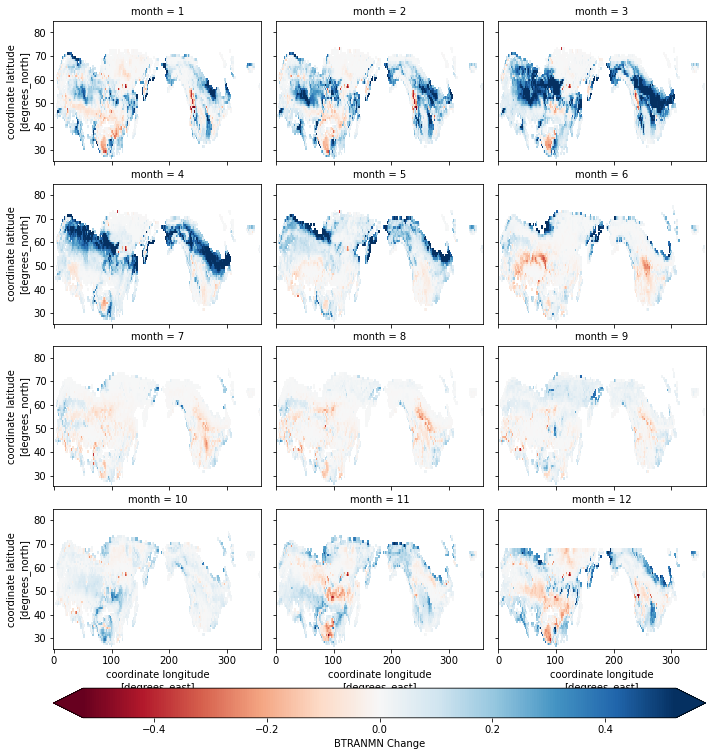

In [55]:
plotVar = 'BTRANMN'
simple=(FinClimoMean[plotVar]-IniClimoMean[plotVar]).plot(
    y='lat',x='lon',col="month", col_wrap=3,cmap='RdBu',robust=True,
    cbar_kwargs={
          "orientation": "horizontal",
          "label": plotVar+" Change",
          "pad": 0.05,
      }  # passed to plt.colorbar
)

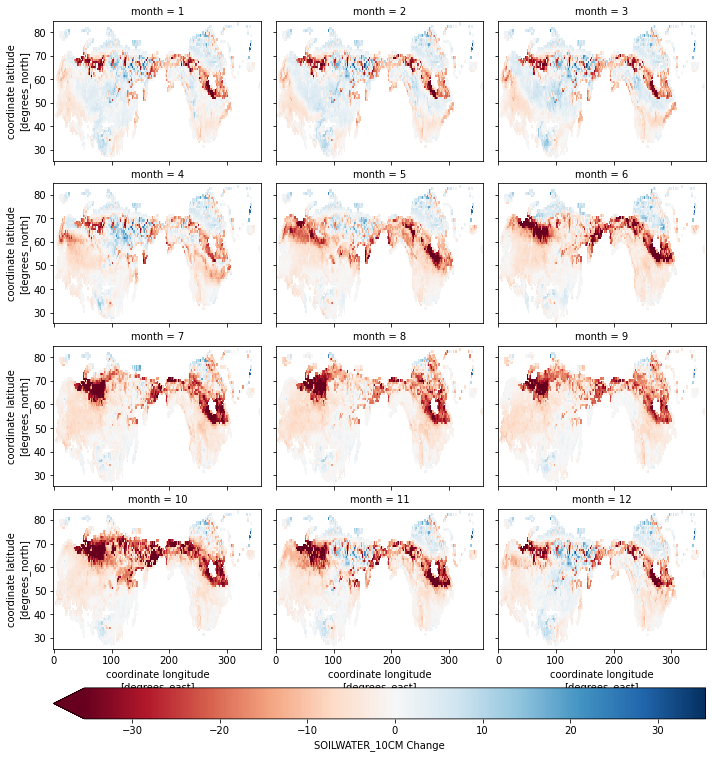

In [56]:
plotVar = 'SOILWATER_10CM'
simple=(FinClimoMean[plotVar]-IniClimoMean[plotVar]).plot(
    y='lat',x='lon',col="month", col_wrap=3,cmap='RdBu',robust=True,
    cbar_kwargs={
          "orientation": "horizontal",
          "label": plotVar+" Change",
          "pad": 0.05,
      }  # passed to plt.colorbar
)


-------
### END OF NOTEBOOK... So far...
------

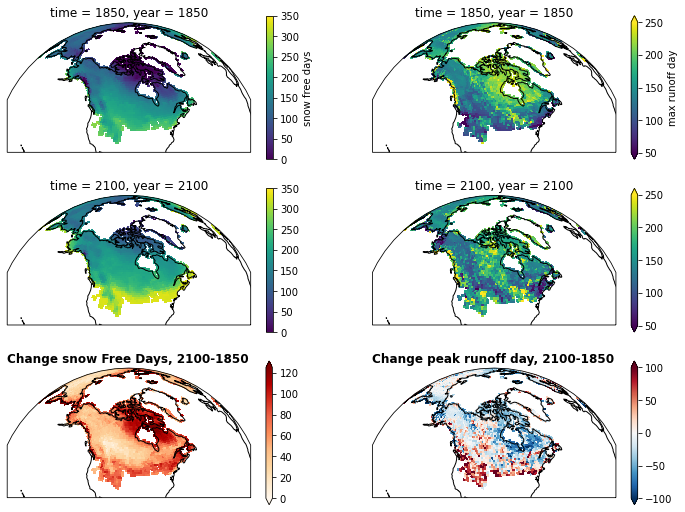

In [37]:
# Number of snow free days
plotVar = ['SnowFree','MaxQrunDate']
#lat,lon,region,ortho = [25,80], [0,360], 'Europe', [80,30]
lat,lon,region,ortho = [35,85], [0,360], 'W. NA',[-100,30]
dsWest =  ds_ensMean.sel(lat=slice(lat[0],lat[1]), lon=slice(lon[0],lon[1]))

f, ((ax1, ax2),(ax3, ax4),(ax5,ax6))= plt.subplots(
    3,2, figsize=(12, 9),sharey='row',sharex='col',
    subplot_kw=dict(projection=ccrs.Orthographic(ortho[0], ortho[1])) )

# free days 1901 
dsWest[plotVar[0]].isel(time=0).plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),  # this is important!
    vmax=350, vmin=0,cbar_kwargs={'label': 'snow free days'}) ;
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.coastlines()  # cartopy function

dsWest[plotVar[1]].isel(time=0).plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),  # this is important!
    vmax=250, vmin=50,cbar_kwargs={'label': 'max runoff day'}) ;
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.coastlines()  # cartopy function

# free days 2100 
dsWest[plotVar[0]].isel(time=-1).plot(
    ax=ax3,
    transform=ccrs.PlateCarree(),  # this is important!
    vmax=350, vmin=0,cbar_kwargs={'label': ''}) ;
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.coastlines()  # cartopy function

dsWest[plotVar[1]].isel(time=-1).plot(
    ax=ax4,
    transform=ccrs.PlateCarree(),  # this is important!
    vmax=250, vmin=50,cbar_kwargs={'label': ''}) ;
ax4.set_xlabel('')
ax4.set_ylabel('')
ax4.coastlines()  # cartopy function

# Change  2100 - 1901
ax5.set_title('Change snow Free Days, 2100-1850',loc='left', fontsize='large', fontweight='bold')
(dsWest[plotVar[0]].isel(time=-1) - dsWest[plotVar[0]].isel(time= 0)).plot(
    ax=ax5,
    transform=ccrs.PlateCarree(),  # this is important!
    vmax=125,vmin=0, cbar_kwargs={'label': ''},cmap='OrRd') ;
ax5.set_xlabel('')
ax5.set_ylabel('')
ax5.coastlines()  # cartopy function

ax6.set_title('Change peak runoff day, 2100-1850',loc='left', fontsize='large', fontweight='bold')
(dsWest[plotVar[1]].isel(time=-1) - dsWest[plotVar[1]].isel(time= 0)).plot(
    ax=ax6,
    transform=ccrs.PlateCarree(),  # this is important!
    vmax=100,vmin=-100, cbar_kwargs={'label': ''},cmap='RdBu_r') ;
ax6.set_xlabel('')
ax6.set_ylabel('')  
ax6.coastlines() ;  # cartopy function

### Start by looking at a single gridcell

CPU times: user 7.76 s, sys: 423 ms, total: 8.18 s
Wall time: 21 s


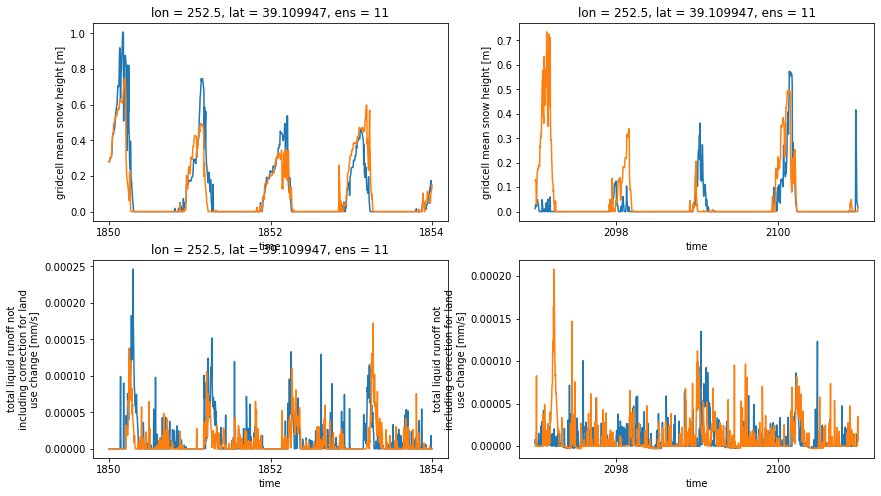

#### Look at changes in snow depth & vernal window, single site

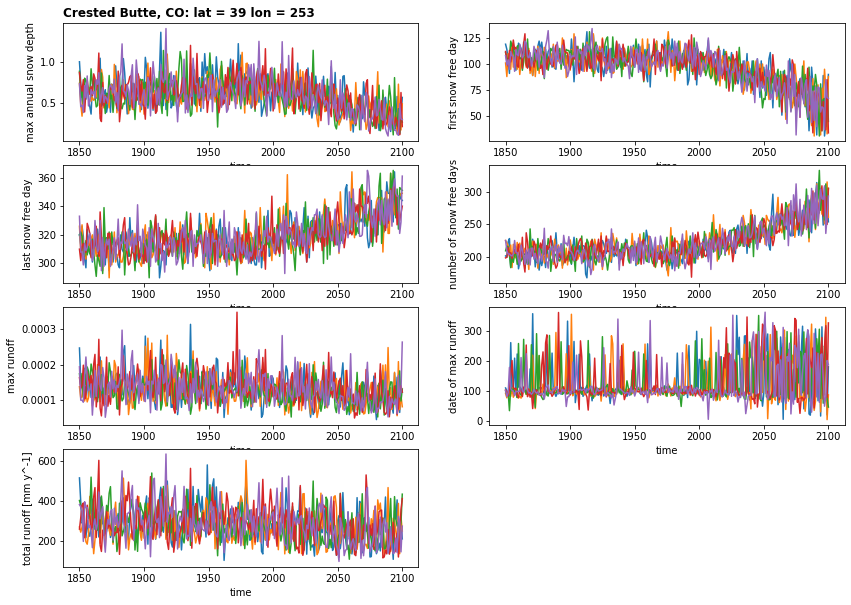

In [40]:
# Plotting daily data takes forever... may skip this?
# look at raw data
plt.figure(figsize=[14,10])
for i in range(len(sno_vars)):
    plt.subplot(4,2,(i+1))
    dsPTANN[sno_vars[i]].plot(hue='ens',add_legend=False)  
    plt.title(" ") ;
    if i == 0: plt.title(site+': lat = '+str(plat)+' lon = '+str(plon), 
                         loc='left', fontsize='large', fontweight='bold') 
    

<Figure size 1008x792 with 0 Axes>

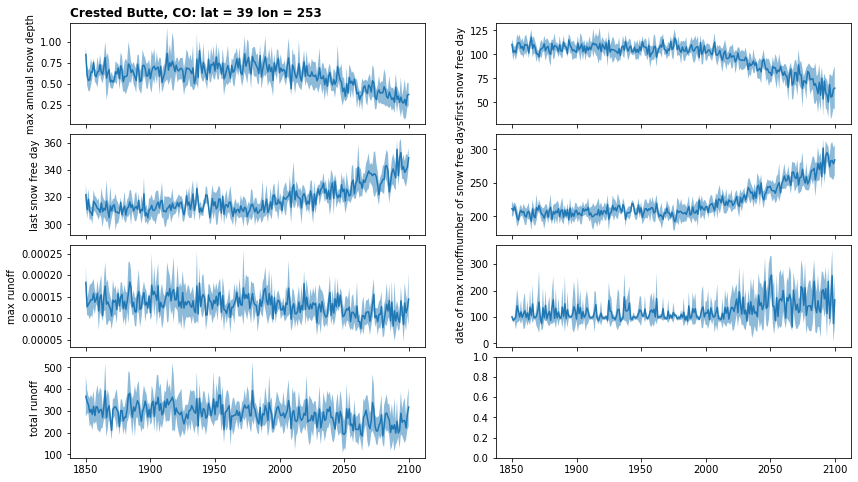

In [41]:
plt.figure(figsize=[14,11])
fig, axs = plt.subplots(4,2, sharex=True,
                        gridspec_kw={'wspace': 0.2, 'hspace': 0.1},
                        figsize=(14,8))
i,j = 0,0
for v in range(len(sno_vars)):
    x = ds_ensMean.time
    y = ds_ensMean[sno_vars[v]].sel(lat = plat, lon = plon, method='nearest')
    y2 = ds_ensStd[sno_vars[v]].sel(lat = plat, lon = plon, method='nearest')
        
    axs[i,j].plot(x, y, '-')
    axs[i,j].fill_between(x, y - y2, y + y2, alpha=0.5)
    axs[i,j].set_ylabel(dsANN[sno_vars[v]].attrs['long_name']) ;
    if v == 0: 
        axs[i,j].set_title(site+': lat = '+str(plat)+' lon = '+str(plon), 
                           loc='left', fontsize='large', fontweight='bold') 
    # move counter for panel
    j = j+1
    if j == 2:
        i = i+1
        j = 0

Work computing time of emergce for chagnes in the 'vernal window', 
- below dive into changes in snow and soil temperature over time

## Flavio defined ToE as time when 10 year running mean > baseline
#### Here we'll take: 
- 30 year baseline (1850-1880)
- 10 year running mean

In [44]:
%%time 
# ensemble mean and std over first 30 years
dsBase    = dsANN.isel(time=slice(0,30)).mean(dim=['time','ens']).compute()
dsBaseStd = dsANN.isel(time=slice(0,30)).std(dim=['time','ens']).compute()
#print(dsBase)

CPU times: user 1min 9s, sys: 1.92 s, total: 1min 10s
Wall time: 1min 22s


### TODO
- do you take ensemble mean over years, and then 10 year rolling mean?
- here take rolling mean of each ensemble, then take ensemble statistics.

In [43]:
%%time 
#roll_ensMean = ds_ensMean.chunk({"time": 201}).rolling(time=11, center=True).mean(dim='time')
ds_roll = dsANN.chunk({"time": 251}).rolling(time=11, center=True).mean().compute()
# Then take mean and std over rolling mean
roll_ensMean = ds_roll.mean('ens').compute()
roll_ensStd  = ds_roll.std('ens').compute()

CPU times: user 2min 20s, sys: 9.21 s, total: 2min 30s
Wall time: 3min 39s


#### Plot: 
* ensemble mean & standard deviation
* rolling mean & rolling std
* base mean and std (all ensembles over first 20 years)

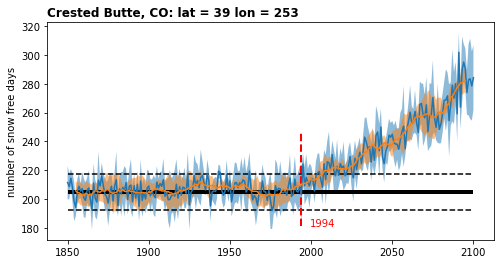

In [45]:
plat, plon, site =  39 , 253  , 'Crested Butte, CO'
#plat, plon, site = 64.8, 212.4, 'Fairbanks, AK'

plt.figure(figsize=[8,4])
x = ds_ensMean.time
y = ds_ensMean['SnowFree'].sel(lat = plat, lon = plon, method='nearest')
y2 = ds_ensStd['SnowFree'].sel(lat = plat, lon = plon, method='nearest')
        
plt.plot(x, y, '-')
plt.fill_between(x, y - y2, y + y2, alpha=0.5)
plt.ylabel(dsANN['SnowFree'].attrs['long_name']) ;

x = roll_ensMean.time
y = roll_ensMean.SnowFree.sel(lat = plat, lon = plon, method='nearest')
y2= roll_ensStd.SnowFree.sel(lat = plat, lon = plon, method='nearest')
plt.plot(x, y)
plt.fill_between(x, y - 2*y2, y + 2*y2, alpha=0.5)

plt.hlines(dsBase.SnowFree.sel(lat = plat, lon = plon, method='nearest'), 1850, 2100, colors='k',lw=4) ;
plt.hlines((dsBase.SnowFree + dsBaseStd.SnowFree).sel(lat = plat, lon = plon, method='nearest'),
           1850, 2100, colors='k',linestyles='dashed') ;
plt.hlines((dsBase.SnowFree - dsBaseStd.SnowFree).sel(lat = plat, lon = plon, method='nearest'),
           1850, 2100, colors='k',linestyles='dashed') 
plt.title(site+': lat = '+str(plat)+' lon = '+str(plon), 
                           loc='left', fontsize='large', fontweight='bold') ;

# find last day when roll mean - 2 std < baseline
test = y - 2*y2
test = test.where(test<dsBase.SnowFree.sel(lat = plat, lon = plon, method='nearest')).dropna('time')
ToE = test.time.isel(time=-1)
plt.vlines(ToE, test.min()*0.95,test.max()*1.2,colors='r',lw=2,linestyles='dashed') ;
plt.text(ToE+5, test.min()*0.95, ToE.values,color='r') ;

#### Test code for all variables

<Figure size 1008x792 with 0 Axes>

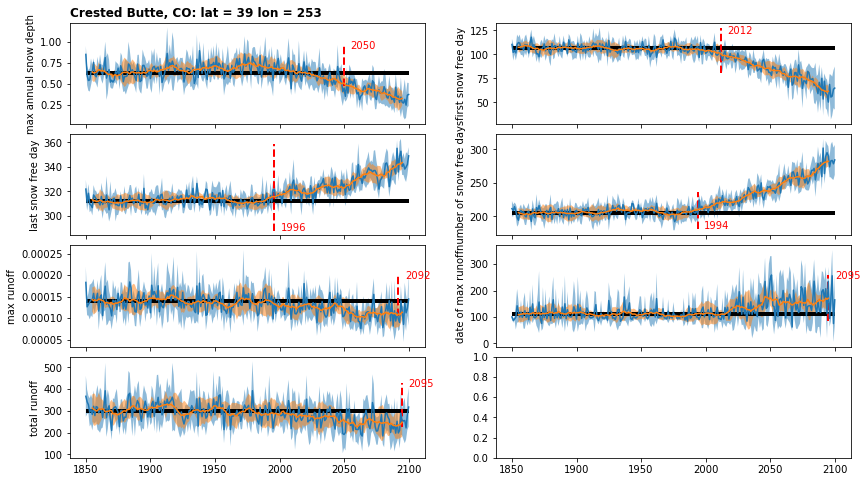

In [48]:
plat, plon, site =  39 , 253  , 'Crested Butte, CO' 
#plat, plon, site = 64.8, 212.4, 'Fairbanks, AK'
#plat, plon, site =  64 , 12.1  , 'Random point' 

sno_vars = ['MaxSnow','LastSnow','FirstSnow','SnowFree','MaxQrun','MaxQrunDate','TotQrun']
sno_trend = ['neg'   ,'neg'     ,'pos'      ,'pos'     ,'neg'    ,'neg'        ,'neg']
plt.figure(figsize=[14,11])
fig, axs = plt.subplots(4,2, sharex=True,
                        gridspec_kw={'wspace': 0.2, 'hspace': 0.1},
                        figsize=(14,8))
i,j = 0,0
for v in range(len(sno_vars)):
    # ens mean
    x = ds_ensMean.time
    y = ds_ensMean[sno_vars[v]].sel(lat = plat, lon = plon, method='nearest')
    y2 = ds_ensStd[sno_vars[v]].sel(lat = plat, lon = plon, method='nearest')
    axs[i,j].plot(x, y, '-')
    axs[i,j].fill_between(x, y - y2, y + y2, alpha=0.5)
    axs[i,j].set_ylabel(dsANN[sno_vars[v]].attrs['long_name']) ;

    # rolling ensemble mean
    x = roll_ensMean.time
    y = roll_ensMean[sno_vars[v]].sel(lat = plat, lon = plon, method='nearest')
    y2= roll_ensStd[sno_vars[v]].sel(lat = plat, lon = plon, method='nearest')
    axs[i,j].plot(x, y)
    axs[i,j].fill_between(x, y - 2*y2, y + 2*y2, alpha=0.5)

    # baseline
    axs[i,j].hlines(dsBase[sno_vars[v]].sel(
        lat = plat, lon = plon, method='nearest'), 
                    1850, 2100, colors='k',lw=4) ;

    # find last day when roll mean - 2 std < baseline
    if sno_trend[v] == 'pos':  # variables w/ positive trend:
        test = y - 2*y2
        test = test.where(test<dsBase[sno_vars[v]].sel(
            lat = plat, lon = plon, method='nearest')).dropna('time')
    else:
        test = y + 2*y2
        test = test.where(test>dsBase[sno_vars[v]].sel(
            lat = plat, lon = plon, method='nearest')).dropna('time')

    ToE = test.time.isel(time=-1)

    if sno_trend[v] == 'pos': 
        axs[i,j].vlines(ToE, test.min()*0.95,test.max()*1.15,colors='r',
                        lw=2,linestyles='dashed') ;
        axs[i,j].text(ToE+5, test.min()*0.95, ToE.values,color='r')
    else: 
        axs[i,j].vlines(ToE, test.min()*0.75,test.max()*1.1,colors='r',
                        lw=2,linestyles='dashed') ;
        axs[i,j].text(ToE+5, test.max()*1.05, ToE.values,color='r')
    if v == 0: 
        axs[i,j].set_title(site+': lat = '+str(plat)+' lon = '+str(plon), 
                           loc='left', fontsize='large', fontweight='bold') ;
    # move counter for panel
    j = j+1
    if j == 2:
        i = i+1
        j = 0 ;

#### Time of emergence globally

<xarray.DataArray 'time' ()>
array(1994)
Coordinates:
    lon      float32 252.5
    lat      float32 39.11


<xarray.DataArray 'time' ()>
array(2100)

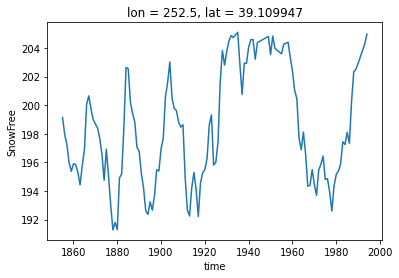

In [49]:
import cartopy.crs as ccrs
# find ToE for Snow free days when roll mean - 2 std < baseline
test = roll_ensMean.SnowFree - 2*roll_ensStd.SnowFree
test = test.where(test<dsBase.SnowFree)
GOI = (test.sel(lat = plat, lon = plon, method='nearest')).dropna('time')
print(GOI.time.max())#isel(time=-1))
GOI.plot()

test.time.max()#.groupby()['time'].max()
#test.time.dropna('time').plot()
#test = test.idxmax(dim='time')
#test.where(test>1850).sel(lon=slice(5,44),lat=slice(50,77)).plot(    
    #transform=ccrs.PlateCarree(),  # remember to provide this!
    #subplot_kws={
    #    "projection": ccrs.LambertConformal(
    #        central_longitude=0, central_latitude=60
    #    )
    #},
#    robust=True) ;
#print(test)

<xarray.DataArray 'time' (lat: 63, lon: 288)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float32 25.92 26.86 27.8 28.74 ... 81.52 82.46 83.4 84.35


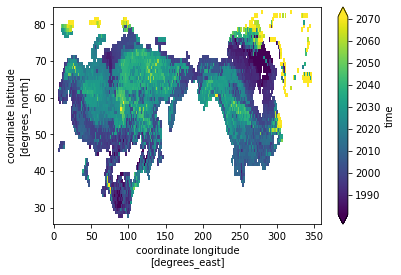

In [50]:
ToE_coords = test.coords
ToE = xr.Dataset(coords=ToE_coords)

for v in range(len(sno_vars)):
    if sno_trend[v] == 'pos':  # variables w/ positive trend:
        temp = roll_ensMean[sno_vars[v]] - 2*roll_ensStd[sno_vars[v]]
        temp = temp.time.where(temp<dsBase[sno_vars[v]])
    else:
        temp = roll_ensMean[sno_vars[v]] + 2*roll_ensStd[sno_vars[v]]
        temp = temp.time.where(temp>dsBase[sno_vars[v]])
    
    if v == 3:
        print(temp.max(dim='time'))
        temp.max(dim='time').plot(robust=True)
    ToE[sno_vars[v]] = temp.max(dim='time')

    ToE = ToE.where(ToE>1850)

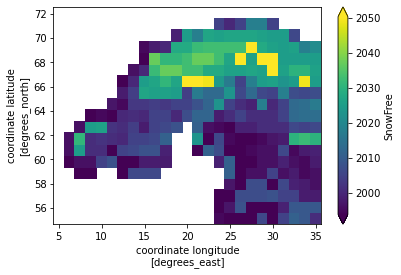

In [51]:
ToE.SnowFree.sel(lon=slice(5,35),lat=slice(55,73)).plot(robust=True) ;

In [52]:
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

# Generate a function for making panel plots of maps
def map_function(da, cb=0, panel=None, cmap=None, ax=None, 
                 title=None, vmax=None, vmin=None):
    '''a function to make one subplot'''
    wrap_data, wrap_lon = add_cyclic_point(da.values, coord=da.lon)

    if ax is None: ax = plt.gca()
    im = ax.pcolormesh(wrap_lon,da.lat,wrap_data,
                   transform=ccrs.PlateCarree(),
                   vmax=vmax,vmin=vmin,cmap=cmap)
    ax.set_title(title)
    ax.coastlines()
    ax.set_extent([-180,180,25,85], crs=ccrs.PlateCarree())
    ax.annotate(panel, xy=(0.05, 0.95), xycoords=ax.transAxes,
                ha='center', va='center',fontsize=16)    

    # allows for different colorbars on each plot
    if cb == 1:
        fig.colorbar(im, ax=ax,pad=0.05, fraction = 0.1, orientation='horizontal')

IndexError: list index out of range

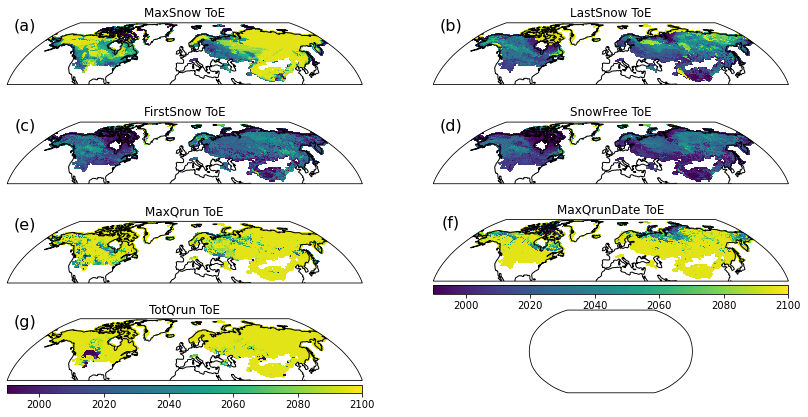

In [55]:
# Now call the map_function
#---------------------
panel = ['(a)','(b)','(c)','(d)','(e)','(f)','(g)',
         '(h)','(i)','(k)','(l)','(m)','(n)']  

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14,7), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
cb = [0,0,0,0,0,1,1]
i = 0
for index, ax in np.ndenumerate(axes):
    #i = index[0]
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    da = ToE[sno_vars[i]]
    map_function(da, panel=panel[i], ax=ax, title=sno_vars[i]+' ToE', 
                 vmin=1990, vmax=2100, cb=cb[i])

    i = i+1

# or to provide a common color bar, set vmax/min so same values and 
#fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5);
#plt.savefig('/glade/scratch/wwieder/svd/'+model+'/'+model+'_Fig_3c_GPP_DTcorr.eps')


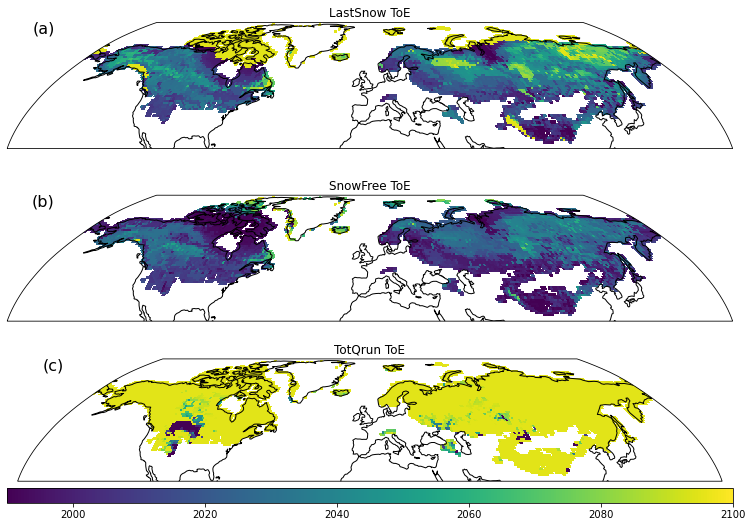

In [60]:
pltVars = ['LastSnow','SnowFree','TotQrun']
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(13,9), constrained_layout=True,
                         subplot_kw=dict(projection=ccrs.Robinson()))
cb = [0,0,1]
i = 0
for index, ax in np.ndenumerate(axes):
    #i = index[0]
    # there are various ways to do this part, index in this case is a tuple (ie `(0, 0)`)
    map_function(ToE[pltVars[i]], panel=panel[i], ax=ax, title= pltVars[i]+' ToE', 
                 cb=cb[i], vmin=1990, vmax=2100) 

    i = i+1

